# Прогнозирование KERAS

In [479]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from time import time
import matplotlib.ticker as tkr

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn import metrics

Задача не просто сделать прогнозы по предыдущим дням - нам необходимо создать окно из этих предыдущих дней (возьмем 30), а прогнозировать будем 30+1 день

In [1]:
# Считаем данные - у нас массив данных по акциям Alphbet (google) с сайта yahoo finannce за последние 5 лет
data = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1446854400&period2=1604707200&interval=1d&events=history&includeAdjustedClose=true")[::-1]

NameError: name 'pd' is not defined

In [481]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1258,2020-11-06,1753.949951,1772.430054,1740.349976,1761.750000,1761.750000,1660900
1257,2020-11-05,1781.000000,1793.640015,1750.510010,1763.369995,1763.369995,2065800
1256,2020-11-04,1710.280029,1771.364990,1706.030029,1749.130005,1749.130005,3570900
1255,2020-11-03,1631.780029,1661.699951,1616.619995,1650.209961,1650.209961,1661700
1254,2020-11-02,1628.160034,1660.770020,1616.030029,1626.030029,1626.030029,2535400


In [482]:
# Даты были в обратном порядке, поэтому отсортируем их
data.sort_index(inplace=True)

In [483]:
data.shape

(1259, 7)

У нас 1259 наблюдений (дней, за которые есть данные за последние 5 лет)

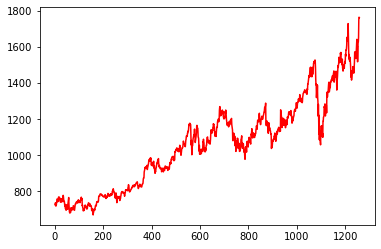

In [484]:
# Нам важна цена закрытия, посмотрим на ее динамику за последние 5 лет:
plt.plot(data.Close, color='r')

## Подготовим данные

In [485]:
# нарезаем с шагом 1 данные по 30 дней для X (данные, на которых мы предсказываем)
# и 30+1 день для Y (то, что именно мы предсказываем)
# Получаем много "окон" из 30 дней и 1 дня после, на которых будем тренировать сет
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [486]:
# У нас 7 столбцов, но прогнозировать мы будем только цену закрытия
dataset = np.array(data.Close)

In [487]:
# Чтобы прогнозировать непрерывные случайные величины, формат чисел должен быть float, а не int
dataset = dataset.astype('float32')

In [488]:
# Изменим размерность матрицы
dataset = np.reshape(dataset, (-1, 1))

In [489]:
# Приведем все значения в диапазон от 0 до 1 (стандартиизация)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [490]:
# Определим размеры тренировочной и тестовой выборки
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

In [491]:
# Разрежем данные на тренировочную и тестовую выборки
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [492]:
# Количество дней, на основе которых мы делаем прогноз (размер окна)
look_back = 30

In [493]:
# Используем написанную ранее функцию для создания данных для обучения нейронной сети
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [494]:
# Для tensorflow нужна следующая размерность [количество выборок, количество дней в окне, количество признаков]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Для такого типа прогнозов (прогноз следующей даты по имеющимся данным за предыдущие дни) один из лучших вариантов - LSTM архитектура рекуррентной нейронной сети

## Построим необходимую модель нейросети: будем использовать LSTM

In [495]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [496]:
# Построим необходимую модель нейросети: будем использовать LSTM

# Предсказываем временные ряды
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))

# Нужно для исключения переобучения: "выбрасываем" на некоторых итерациях случайные нейроны
model.add(Dropout(0.2))

# На выходе должен быть прогноз по 1 дню
model.add(Dense(1))

# Функция ошибок mse, оптимизатор ADAM
model.compile(loss='mean_squared_error', optimizer='adam')

# Начнем процесс тренировки модели:
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/500
31/31 [==============================] - 1s 30ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 9/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 10/500
31/31 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0027


## Прогноз

In [497]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [498]:
# Мы до этого сжали данные в отрезок от 0 до 1, теперь вернем их в исходное состояние
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [499]:
# Выведем ошибки модели
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 14.358716801578465
Train Root Mean Squared Error: 19.850046079662608
Test Mean Absolute Error: 34.70332029872818
Test Root Mean Squared Error: 43.71936011004853


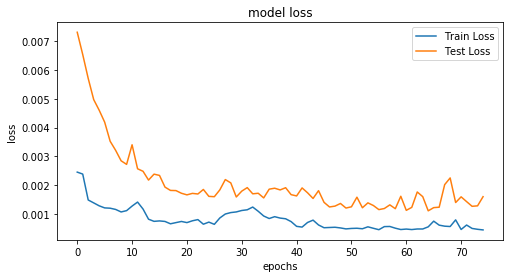

In [500]:
# Выведем функцию ошибок от количества итераций обучения модели
# Видно, что после 10 улучшение прогноза с каждой итерацией обучения снижается

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


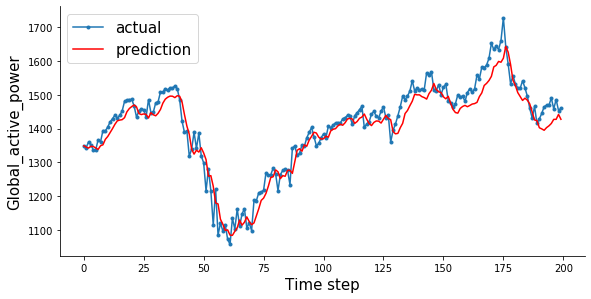

In [501]:
# Посмотрим на 200 выборок из тестовых данных
aa=[x for x in range(200)]

# Построим график и посмотрим, насколько хорошо сеть предсказывает тестовую выборку
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();